In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [29]:
# Load the datasets
users = pd.read_csv('drive/MyDrive/users.csv')
places = pd.read_csv('drive/MyDrive/all_places.csv', encoding='MacRoman')
ratings = pd.read_csv('drive/MyDrive/ratings.csv')

In [30]:
# Step 1: Calculate the average rating for each place
average_ratings = ratings.groupby('Place ID')['Rating'].mean()

# Step 2: Merge average ratings with the places DataFrame
places = places.merge(average_ratings, left_on='id', right_index=True, how='left')

# Step 3: Rename the merged column to "average rating"
places = places.rename(columns={'Rating': 'Avg rating'})

# Step 4: Fill NaN values with a default value (e.g., 0)
places['Avg rating'] = places['Avg rating'].fillna(0)

places['price'] = places['price'].fillna(0)

In [31]:
users.head()

,id,user_name,email,gender,age,country
0,1,Sparhawk,wsparhawk0@va.gov,Female,37,Brazil
1,2,Albery,talbery1@goo.gl,Male,31,Cuba
2,3,Andresen,fandresen2@jiathis.com,Male,44,Bosnia and Herzegovina
3,4,Tansill,stansill3@salon.com,Male,27,South Africa
4,5,Jeffels,ojeffels4@dedecms.com,Female,52,China


In [32]:
places.head()

,id,name,address,city_id,location,desciption,time,stars,food type,price,place_type,Avg rating
0,1,Galleria Alberto Sordi,Piazza Colonna 00187 Roma RM Italy,1,41.90122340938924 12.480575693552845,Galleria Alberto Sordi is a historic shopping ...,2.0,NaN,NaN,0.0,shopping,4.101695
1,2,Via del Corso,"Via del Corso, 00186 Roma RM, Italy",1,41.903369974944845 12.479473708895839,Via del Corso is one of the main shopping stre...,3.0,NaN,NaN,0.0,shopping,3.784314
2,3,Via Condotti,"Via dei Condotti, 00187 Roma RM, Italy",1,41.90533403993258 12.480541881910383,"Via Condotti is a prestigious street in Rome, ...",4.0,NaN,NaN,0.0,shopping,4.074074
3,4,La Rinascente,"Via del Tritone, 61, 00187 Roma RM, Italy",1,41.90600659996459 12.484760359092748,La Rinascente is a famous department store in ...,4.0,NaN,NaN,0.0,shopping,3.785714
4,5,Porta Portese Market,"Via di Porta Portese, 00153 Roma RM, Italy",1,41.87621365001004 12.467844220464272,Porta Portese Market is one of the largest fle...,5.0,NaN,NaN,0.0,shopping,4.192982


In [33]:
# Merge datasets based on user and place IDs
merged_data = ratings.merge(places, left_on='Place ID', right_on='id').merge(users, left_on='User ID', right_on='id')

In [34]:
# Calculate average rating per place_type per user
avg_ratings = merged_data.groupby(['User ID', 'place_type'])['Rating'].mean().reset_index()

# Pivot the data to create columns for each place_type
avg_ratings_pivot = avg_ratings.pivot(index='User ID', columns='place_type', values='Rating')

# Add the new columns to merged_df
merged_df = merged_data.merge(avg_ratings_pivot, on='User ID')

# Rename the columns
merged_df.rename(columns={'Shopping': 'Shopping Avg',
                          'Hotel': 'Hotel Avg',
                          'Night': 'Night Avg',
                          'Old': 'Old Avg'}, inplace=True)

In [35]:
merged_df.head()

,User ID,Place ID,Rating,id_x,name,address,city_id,location,desciption,time,...,email,gender,age,country,hotel,natural,night,old,restaurant,shopping
0,1,13,4,13,Maximo Shopping Center,"Via Laurentina, 865, 00143 Roma RM, Italy",1,41.810083544780966 12.486444743207326,Maximo Shopping Center is a modern retail comp...,5.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.4,3.571429,3.25,3.5,3.545455,4.571429
1,1,47,5,47,La Reggia Designer Outlet,"S.S. Sannitica, 81025 Marcianise CE, Italy (ne...",3,41.006592213103936 14.321363645831704,La Reggia Designer Outlet: A large outlet mall...,3.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.4,3.571429,3.25,3.5,3.545455,4.571429
2,1,58,4,58,Centro Direzionale,"Via Galileo Ferraris, 80142 Naples NA, Italy.",3,40.858385900986974 14.283541876067877,Centro Direzionale: A business district that a...,2.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.4,3.571429,3.25,3.5,3.545455,4.571429
3,1,80,5,80,I Tre Mercanti,"Calle dei Fabbri, 1323, 30124 Venice, Italy",5,45.436382840786166 12.339383724477264,Elegant boutique carrying gourmet Italian food...,3.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.4,3.571429,3.25,3.5,3.545455,4.571429
4,1,84,4,84,Ponte Vecchio,"Across the Arno River, Florence",4,43.76806443138688 11.253186411838058,Historic bridge with jewelry shops.,5.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.4,3.571429,3.25,3.5,3.545455,4.571429


In [36]:
# Prepare the data for modeling
X = merged_df[['age', 'gender', 'country', 'place_type', 'hotel', 'natural',	'night',	'old',	'restaurant', 'shopping', 'Avg rating','price']]
Y = merged_df['Rating'].values

In [37]:
# Encode categorical variables
gender_encoder = LabelEncoder()
country_encoder = LabelEncoder()
place_type_encoder = LabelEncoder()

gender_encoder.fit(X['gender'])
country_encoder.fit(X['country'])
place_type_encoder.fit(X['place_type'])

X.loc[:, 'gender'] = gender_encoder.transform(X.loc[:, 'gender'])
X.loc[:, 'country'] = country_encoder.transform(X.loc[:, 'country'])
X.loc[:, 'place_type'] = place_type_encoder.transform(X.loc[:, 'place_type'])

In [38]:
X

,age,gender,country,place_type,hotel,natural,night,old,restaurant,shopping,Avg rating,price
0,37,0,10,5,3.400000,3.571429,3.25,3.500,3.545455,4.571429,4.022727,0.0
1,37,0,10,5,3.400000,3.571429,3.25,3.500,3.545455,4.571429,4.016129,0.0
2,37,0,10,5,3.400000,3.571429,3.25,3.500,3.545455,4.571429,4.106383,0.0
3,37,0,10,5,3.400000,3.571429,3.25,3.500,3.545455,4.571429,4.086957,0.0
4,37,0,10,5,3.400000,3.571429,3.25,3.500,3.545455,4.571429,3.944444,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
34539,23,1,26,3,3.111111,3.800000,4.20,3.625,3.400000,3.666667,3.785714,17.0
34540,23,1,26,3,3.111111,3.800000,4.20,3.625,3.400000,3.666667,3.881356,9.0
34541,23,1,26,2,3.111111,3.800000,4.20,3.625,3.400000,3.666667,3.600000,60.0
34542,23,1,26,3,3.111111,3.800000,4.20,3.625,3.400000,3.666667,3.872727,0.0


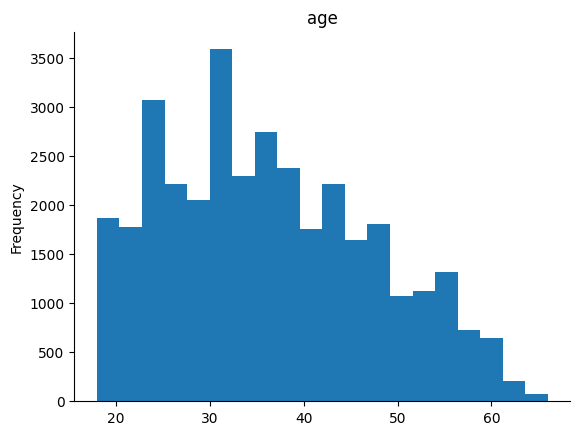

In [39]:
# @title age

from matplotlib import pyplot as plt
X['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

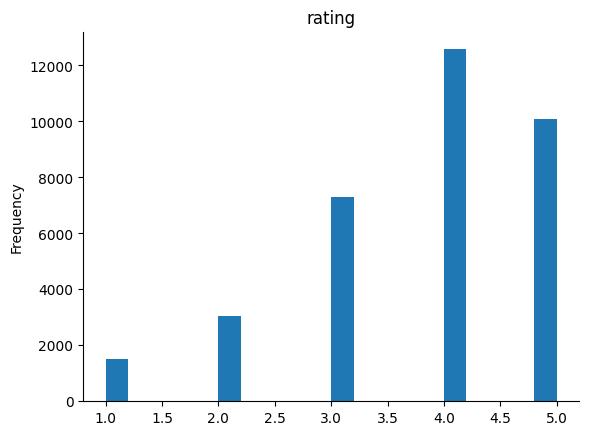

In [13]:
# @title rating

merged_data['Rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [40]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X_scaled

array([[ 0.06727029, -1.24678096, -1.17445814, ...,  1.13048329,
         1.20411401, -0.60300576],
       [ 0.06727029, -1.24678096, -1.17445814, ...,  1.13048329,
         1.17256436, -0.60300576],
       [ 0.06727029, -1.24678096, -1.17445814, ...,  1.13048329,
         1.6041158 , -0.60300576],
       ...,
       [-1.19698134,  0.8020655 , -0.60102934, ..., -0.56583918,
        -0.81716671,  0.06553624],
       [-1.19698134,  0.8020655 , -0.60102934, ..., -0.56583918,
         0.48688537, -0.60300576],
       [-1.19698134,  0.8020655 , -0.60102934, ..., -0.56583918,
         1.58169971, -0.60300576]])

In [42]:
# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, train_size=0.80, shuffle=True, random_state=1)

In [43]:
# Build a sequential regression model
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X_scaled.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [45]:
# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=12, validation_data=(x_test, y_test))

Epoch 1/15
2303/2303 [==============================] - 12s 3ms/step - loss: 0.9420 - val_loss: 0.8447
Epoch 2/15
2303/2303 [==============================] - 7s 3ms/step - loss: 0.8700 - val_loss: 0.8399
Epoch 3/15
2303/2303 [==============================] - 6s 2ms/step - loss: 0.8417 - val_loss: 0.8182
Epoch 4/15
2303/2303 [==============================] - 8s 4ms/step - loss: 0.8237 - val_loss: 0.8004
Epoch 5/15
2303/2303 [==============================] - 6s 2ms/step - loss: 0.8166 - val_loss: 0.7921
Epoch 6/15
2303/2303 [==============================] - 6s 3ms/step - loss: 0.8119 - val_loss: 0.7900
Epoch 7/15
2303/2303 [==============================] - 7s 3ms/step - loss: 0.8088 - val_loss: 0.7891
Epoch 8/15
2303/2303 [==============================] - 5s 2ms/step - loss: 0.8073 - val_loss: 0.7879
Epoch 9/15
2303/2303 [==============================] - 7s 3ms/step - loss: 0.8052 - val_loss: 0.7893
Epoch 10/15
2303/2303 [==============================] - 5s 2ms/step - loss: 0.80

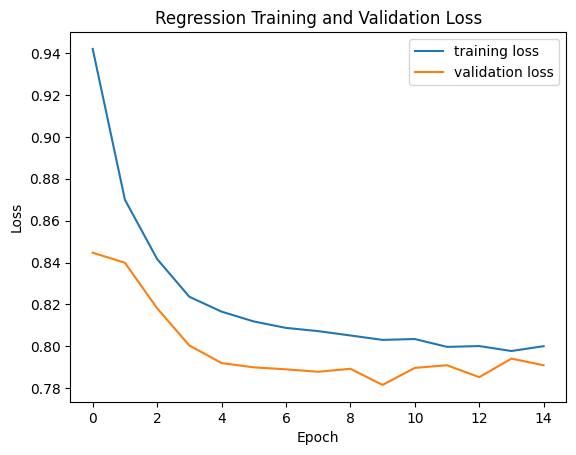

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Regression Training and Validation Loss')
plt.legend()
plt.show()

In [47]:
y_pred = model.predict(x_test)

216/216 [==============================] - 0s 1ms/step


In [48]:
y_pred

array([[3.9838452],
       [3.9838452],
       [3.9838452],
       ...,
       [3.9838452],
       [3.9838452],
       [3.9838452]], dtype=float32)

In [49]:
# Evaluate the model on the test set
loss = model.evaluate(x_test, y_test)
loss

216/216 [==============================] - 0s 2ms/step - loss: 0.7910


0.7910014986991882

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate additional metrics
predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Print the evaluation results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

216/216 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.79
Mean Squared Error (MSE): 1.13
Root Mean Squared Error (RMSE): 1.06


In [53]:
# Calculate the range of the target variable
y_range = y_test.max() - y_test.min()

# Compute the loss as a percentage
loss_percentage = (mse / y_range) * 100

# Print the loss percentage
print(f"Loss Percentage: {loss_percentage:.2f}%")

Loss Percentage: 28.31%
